In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from string import punctuation
# import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from pymorphy2 import MorphAnalyzer
from spellchecker import SpellChecker
from autocorrect import Speller
from navec import Navec

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import PredefinedSplit, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [4]:
df = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip')

In [5]:
df.head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


## L0. Формализация задачи и определение таргета

* **Формализация задачи:**  
Задача бинарной классификации  
  
* **Целевая переменная:**  
Таргет (столбец "label") - является ли отзыв фейковым. 1 - отзыв фейковый, 0 - отзыв настоящий  
  
* **Метрики:**
    1. Accuracy. Как будет показано далее в разделе, который посвящен EDA, имеет место серьезный дисбаланс классов, поэтому в данном случае метрику accuracy использовать не будем
    2. Precision и Recall. Если мы будем пытаться максимизировать только точность (Precision), не обращая внимание на полноту (Recall), то в ситуации, если мы получим высокую точность и низкую полноту, получится, что наша модель корректно относит отзывы к фейковым, но при этом мы выявляем далеко не все фейковые отзывы (из-за низкой полноты), что, скорее всего, с точки зрения бизнеса плохо. Рассмотрим теперь противоположную ситуацию: мы фокусируемся только на Recall и наша модель имеет высокую полноту и низкую точность, тогда получится, что модели удается выявить бОльшую часть фейковых отзывов, но при этом модель часть настоящих отзывов отнесла к фейковым, что опять же нехорошо с точки зрения бизнеса.
    3. F-мера. F-мера объединяет точность и полноту, поэтому в качестве основной метрики выберем её.

In [6]:
df.label.unique()

array([0, 1], dtype=int64)

In [7]:
real_sample = df[df.label == 0].text.head(7).to_list()
for i, s in enumerate(real_sample):
    print(i + 1, s)

1 Хотела купить на замену старых,по итогу эти  ужаснотупые ,не удобные ,рвут кутикулу ,а не режут.
2 Кабель подошёл, хорошо работает.
3 Визуально все хорошо. Не пробовали. Купили в подарок
4 Коробка в состоянии,, прошла Афган,,! Гладкая кожа носков сапог тоже уже не выглядит новой. Но сапоги вернула совсем не по этим причинам. Дело в том, что всамой модели сапог странное голенище. Дизайнер просчитался, решил вставить в эскиз замок, хотя стоило обойтись резинкой, дающей возможность вместить любую толщину икры женской ножки. Замок топорщит, держит странную форму, что портит вид сапог.
5 Джинсы хорошие качество отличное но дороговаты и Малы очень  брал на два размера больше но увы так что возврат
6 Камеры не закрывает, камеры в ровень с чехлом
7 Юлия не могли бы Вы проверить стеганку которую я вернула нет ли в карманах ключ от машин, я боюсь что в примерочной я по инерции их положила в карман и вернула позвони если есть по этому номеру 287896096


In [8]:
fake_sample = df[df.label == 1].text.head(7).to_list()
for i, s in enumerate(fake_sample):
    print(i + 1, s)

1 Запах по сравнению с обычным DOVE никакой. Оно не парфюмированное. Только баночки симпатичные и всё
2 Восторг! Очень приятный аромат, держится долго, очень удобный формат для сумочки.
3 Хорошее качество
4 Хорошо упакован, Оригенал 👌🏻спасибо
5 Оыоырыгыоцрцныоцн
6 Доставка-скорость света! Отличная ёмкость, кажется большеватой. НО! под любой стик мыла и пена остаётся внутри и не нужно собирать снаружи. Крышка садится не туго и не болтается. Транспортная упаковка надёжная. Всё без повреждений.
7 Здравствуйте! Товар получила, покупала подарок детям, нам очень понравилась. Соответствует как в картинки рисунки все аккуратно ни какого брака нет, фиксаторы даже запасом есть все отлично👍👍👍👍 спасибо большое за быструю сборку продавцу💐💐💐. И спасибо производителю💋💋💋


## L1. Первичный анализ данных (EDA)

### Посмотрим количество строк и общую информацию

In [9]:
print(f'Датафрейм содержит {df.shape[0]} строк и {df.shape[1]} колонок')

Датафрейм содержит 3123 строк и 13 колонок


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   text    3123 non-null   object 
 4   f1      3123 non-null   int64  
 5   f2      3123 non-null   int64  
 6   f3      3123 non-null   float64
 7   f4      3123 non-null   int64  
 8   f5      3123 non-null   int64  
 9   f6      3123 non-null   float64
 10  f7      3123 non-null   int64  
 11  f8      3123 non-null   int64  
 12  label   3123 non-null   int64  
dtypes: float64(2), int64(7), object(1), uint64(3)
memory usage: 317.3+ KB


### Обработка пропусков

In [11]:
df.isna().sum()

id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

Пропусков (в виде NaN'ов) в таблице нет, но стоит проверить, нет ли в столбце "text" пустых (или например, состоящих только из пробелов) строчек

In [12]:
df[(df.text.str.split().str.len() == 0)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label


Таких пустых строк нет, но есть другая особенность. Взглянем на текст отзыва с индексом 23 из датафрейма

In [13]:
df.loc[23].text

'︎ ︎ ︎ ︎ ︎ ︎'

In [14]:
ord(df.loc[23].text[0])

65038

Визуально кажется, что это строчка из пробелов, но на самом деле она состоит из пробелов, чередующихся с [каким-то непонятным символом unicode](https://symbl.cc/ru/search/?q=65038)

Также обнаружил строку только из нижних подчеркиваний.

In [15]:
df.loc[408].text

'__________'

Эти ситуации будем обрабатывать далее, когда будем выполнять препроцессинг строк

### Проанализируем баланс классов

In [16]:
balance = df.label.value_counts() 
print(f'Выборка содержит {balance.loc[0]} реальных и {balance.loc[1]} фейковых отзывов')

Выборка содержит 2298 реальных и 825 фейковых отзывов


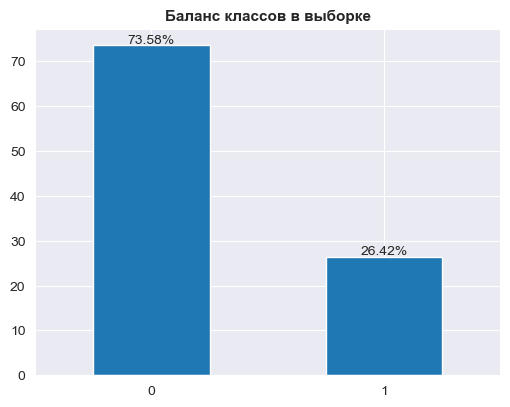

In [17]:
balance = balance * 100 / balance.sum()
ax = balance.plot(kind='bar', figsize=(6, 4.5))
plt.title('Баланс классов в выборке', fontsize=11, weight='bold')
plt.xticks(rotation=0)
for i in balance.index:
    plt.text(i, balance.loc[i] + 0.5, str(round(balance.loc[i], 2)) + '%', ha='center')
plt.show()

**Явный дисбаланс (в выборке преобладают реальные отзывы)**

### Подумаем, что означают прочие столбцы и проанализируем их

**Начнем со столбцов, которые содержат id**

In [18]:
id_cols = ['id1', 'id2', 'id3']
for col in id_cols:
    print(f'Уникальных значений в колонке {col} : {df[col].nunique()} / {len(df)}')

Уникальных значений в колонке id1 : 3049 / 3123
Уникальных значений в колонке id2 : 3006 / 3123
Уникальных значений в колонке id3 : 978 / 3123


переменная "id1" содержит id пользователя, "id2" - id товара?, "id3" содержит id продавца?  
Вывод сделан после просмотра глазами отзывов с одинаковыми айдишниками. Например, для id1 было местами заметно, что пишет один и тот же человек (некоторые отзывы с одинаковым id начинались одинаково), также кажется, что уникальных пользователей, скорее всего, должно быть больше, чем уникальных товаров и продавцов (см. ячейку выше).

**Перейдем к числовым фичам**

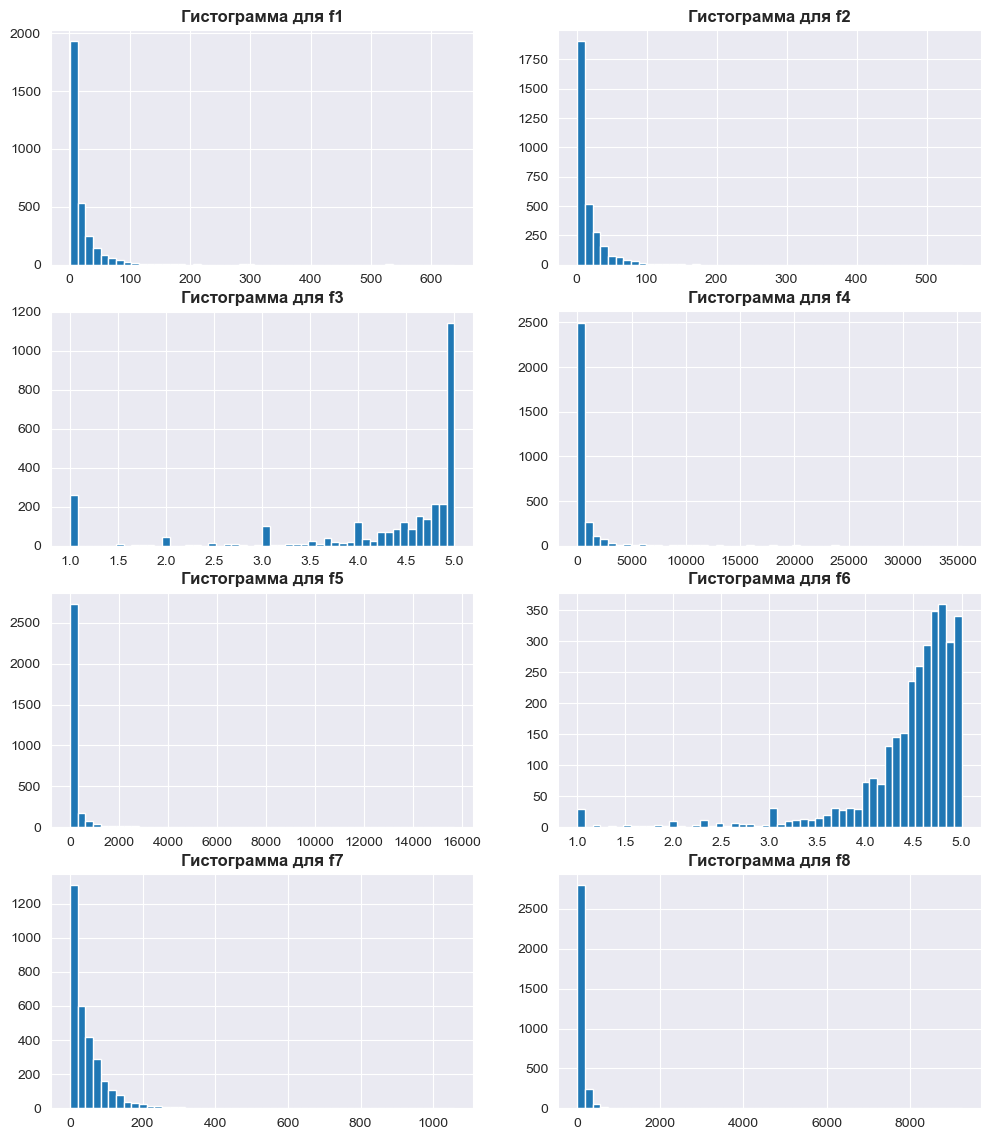

In [19]:
f_cols = ['f' + str(i) for i in range(1, 9)]
plt_arr = np.reshape(f_cols, (4, 2))

fig, axs = plt.subplots(4, 2, figsize=(12, 14))
for i in range(4):
    for j in range(2):
        cur_col = plt_arr[i][j]
        df[cur_col].hist(ax=axs[i][j], bins=50)
        axs[i][j].set_title(f'Гистограмма для {cur_col}', weight='bold')
plt.show()

По гистограммам видно, что для всех переменных, кроме f3 и f6 присутствуют существенные выбросы

Выдвинем предположение о том, что за информация хранится в числовых признаках f1-f8
* f3 - средняя оценка пользователя?
* f6 - средняя оценка товара/продавца?
* f1, f2, f4, f5, f7, f8 - int'ы, возможно, что-то из этого отражает общее количество отзывов у пользователя/товара/продавца  
  
Гипотеза 1: если id1 действительно содержит id пользователя, как я предположил выше, то, скорее всего, фичи f1, f2, f3, f7, f8 содержат какую-то информацию о пользователе, потому что для каждого отдельно взятого значения id1 значения этих признаков не меняются, проверить можно с помощью кода ниже.  
Гипотеза 2: если id2 действительно содержит id товара, как я предположил выше, то, скорее всего, переменная f6 это все-таки средняя оценка товара, а переменные f4, f5 это какие-то другие характеристики товаров (определил, используя аналогичную логику, что и для гипотезы 1, код приведен ниже)

In [20]:
# df.id1.nunique() == df[['id1', 'f1', 'f2', 'f3', 'f7', 'f8']].drop_duplicates().shape[0]

In [36]:
# df[['id2', 'f4', 'f5', 'f6']][df['id2'].duplicated(keep=False)].drop_duplicates().shape[0] == df[df['id2'].duplicated(keep=False)].id2.nunique()

In [14]:
# def box_plt(df, col_name, ax):
#     sns.boxplot(x='label', y=col_name, data=df, ax=ax)
#     ax.set_title(f'Ящик с усами label-{col_name}', 
#                  fontsize=12, weight='bold')
    
# fig, axs = plt.subplots(4, 2, figsize=(10, 16))
# for i in range(4):
#     for j in range(2):
#         cur_col = plt_arr[i][j]
#         box_plt(df, cur_col, axs[i][j])
        
# fig.subplots_adjust(hspace=0.3)
# plt.show()

**Взглянем на описательные статистики**

In [20]:
df.loc[:, 'f1':].describe()

,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


**Корреляции**

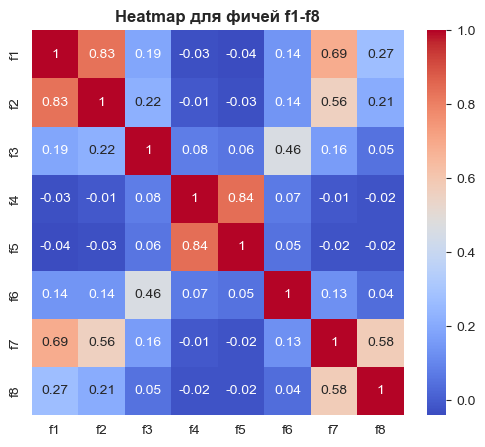

In [21]:
fig = plt.figure(figsize=(6, 5))
sns.heatmap(df[f_cols].corr().round(2), annot=True, cmap='coolwarm')
plt.title('Heatmap для фичей f1-f8', weight='bold')
plt.show()

Как видим, пары переменных f1-f2 и f4-f5 имеют достаточно сильную корреляцию

### Добавим и проанализируем новые признаки

In [22]:
def avg_word_len(s):
    return np.mean(list(map(len, word_tokenize(s, language='russian'))))

def avg_sent_len(s):
    return np.mean(list(map(len, sent_tokenize(s, language='russian'))))

def caps_portion(s, text_len):
    l = re.findall('[А-ЯA-Z]+', s)
    return sum(map(len, l)) / text_len    

def punct_portion(s, text_len):
    l = re.findall(r'[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]+', s)
    return sum(map(len, l)) / text_len  

# def emoji_portion(s, text_len):
#     l = emoji.emoji_count(s)
#     return l / text_len 

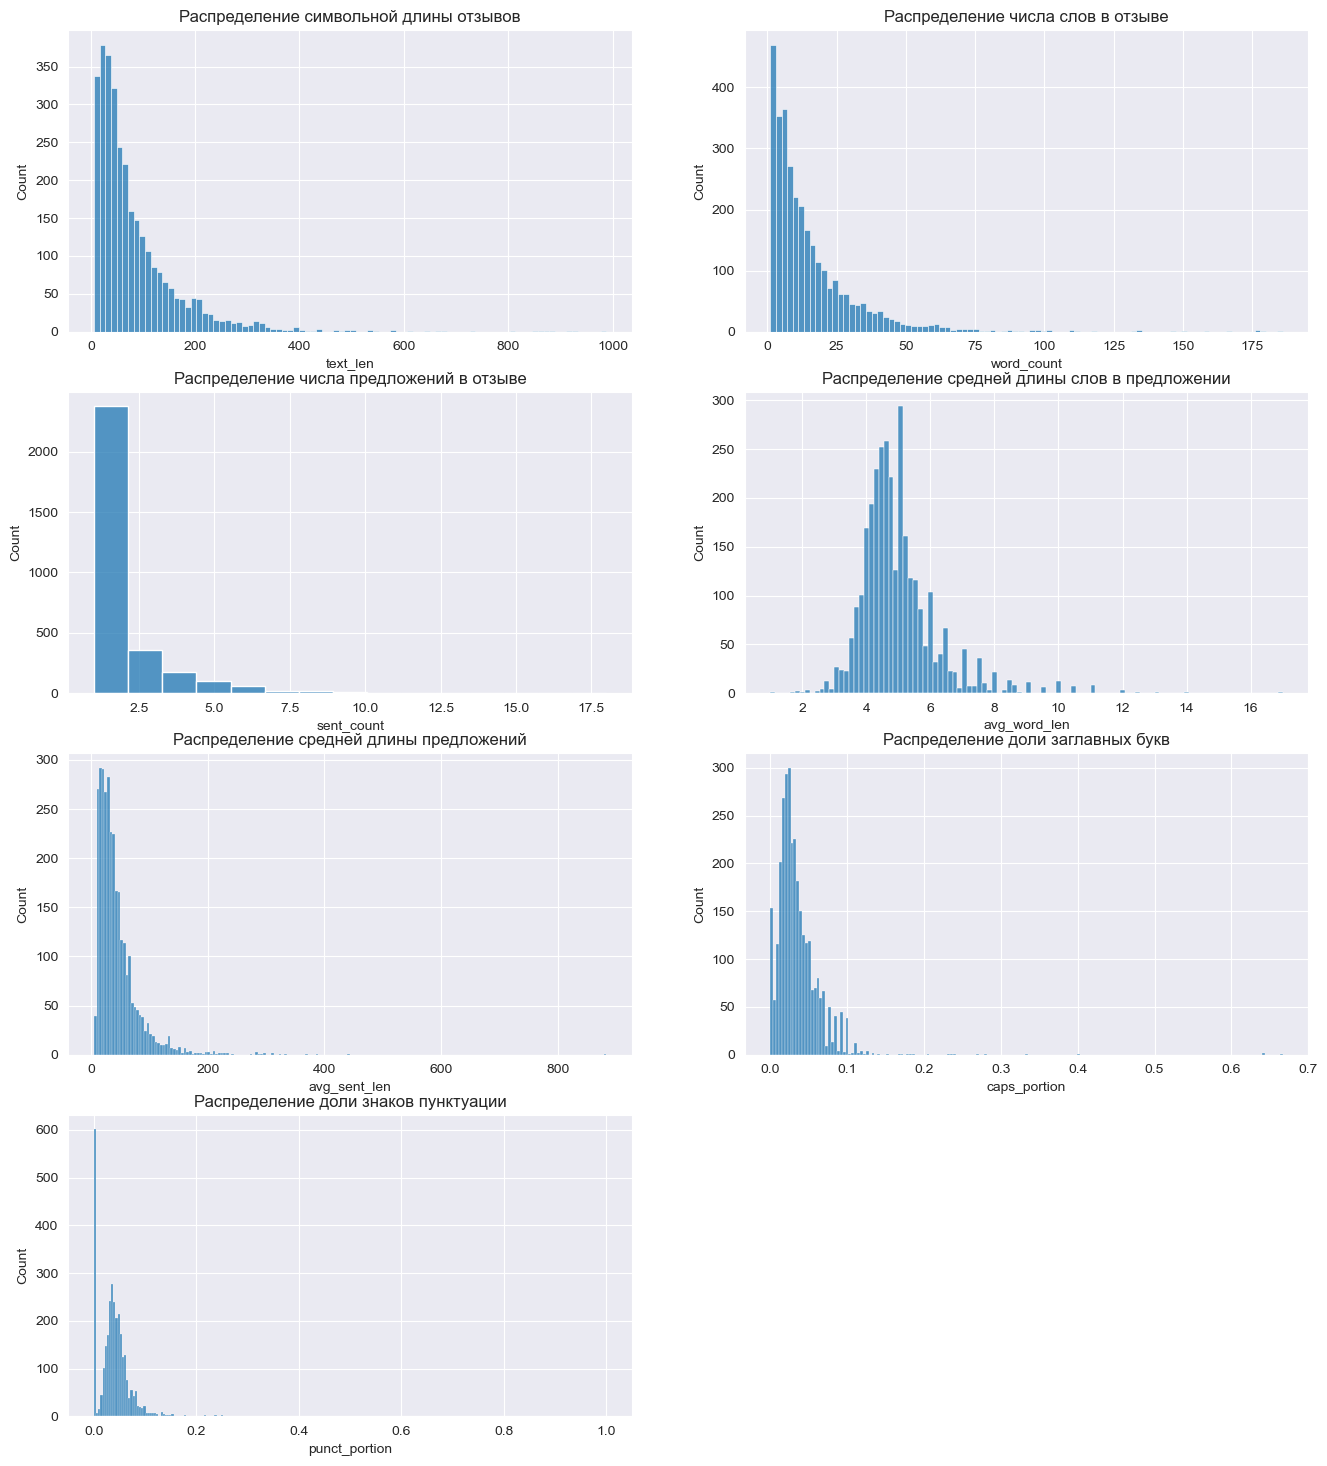

In [23]:
df['text_len'] = df.text.str.len()
df['word_count'] = df.text.apply(lambda x: len(word_tokenize(x, language='russian')))
df['sent_count'] = df.text.apply(lambda x: len(sent_tokenize(x, language='russian')))
df['avg_word_len'] = df.text.apply(avg_word_len)
df['avg_sent_len'] = df.text.apply(avg_sent_len)
df['caps_portion'] = df.apply(lambda x: caps_portion(x.text, x.text_len), axis=1) 
df['punct_portion'] = df.apply(lambda x: punct_portion(x.text, x.text_len), axis=1) 
# df['emoji_portion'] = df.apply(lambda x: emoji_portion(x.text, x.text_len), axis=1) 
df['f9'] = df['f5'] / df['f4'] 
df['f10'] = df['f2'] / df['f1']

fig, ax = plt.subplots(4, 2, figsize=(16, 18))
sns.histplot(data=df.text_len, ax=ax[0][0])
ax[0][0].set_title('Распределение символьной длины отзывов')

sns.histplot(data=df.word_count, ax=ax[0][1])
ax[0][1].set_title('Распределение числа слов в отзыве')

sns.histplot(data=df.sent_count, ax=ax[1][0], bins=15)
ax[1][0].set_title('Распределение числа предложений в отзыве')

sns.histplot(data=df.avg_word_len, ax=ax[1][1])
ax[1][1].set_title('Распределение средней длины слов в предложении')

sns.histplot(data=df.avg_sent_len, ax=ax[2][0])
ax[2][0].set_title('Распределение средней длины предложений')

sns.histplot(data=df.caps_portion, ax=ax[2][1])
ax[2][1].set_title('Распределение доли заглавных букв')

sns.histplot(data=df.punct_portion, ax=ax[3][0])
ax[3][0].set_title('Распределение доли знаков пунктуации')

# sns.histplot(data=df.emoji_portion, ax=ax[3][1])
# ax[3][1].set_title('Распределение доли смайликов')
ax[3][1].axis('off')

plt.show()

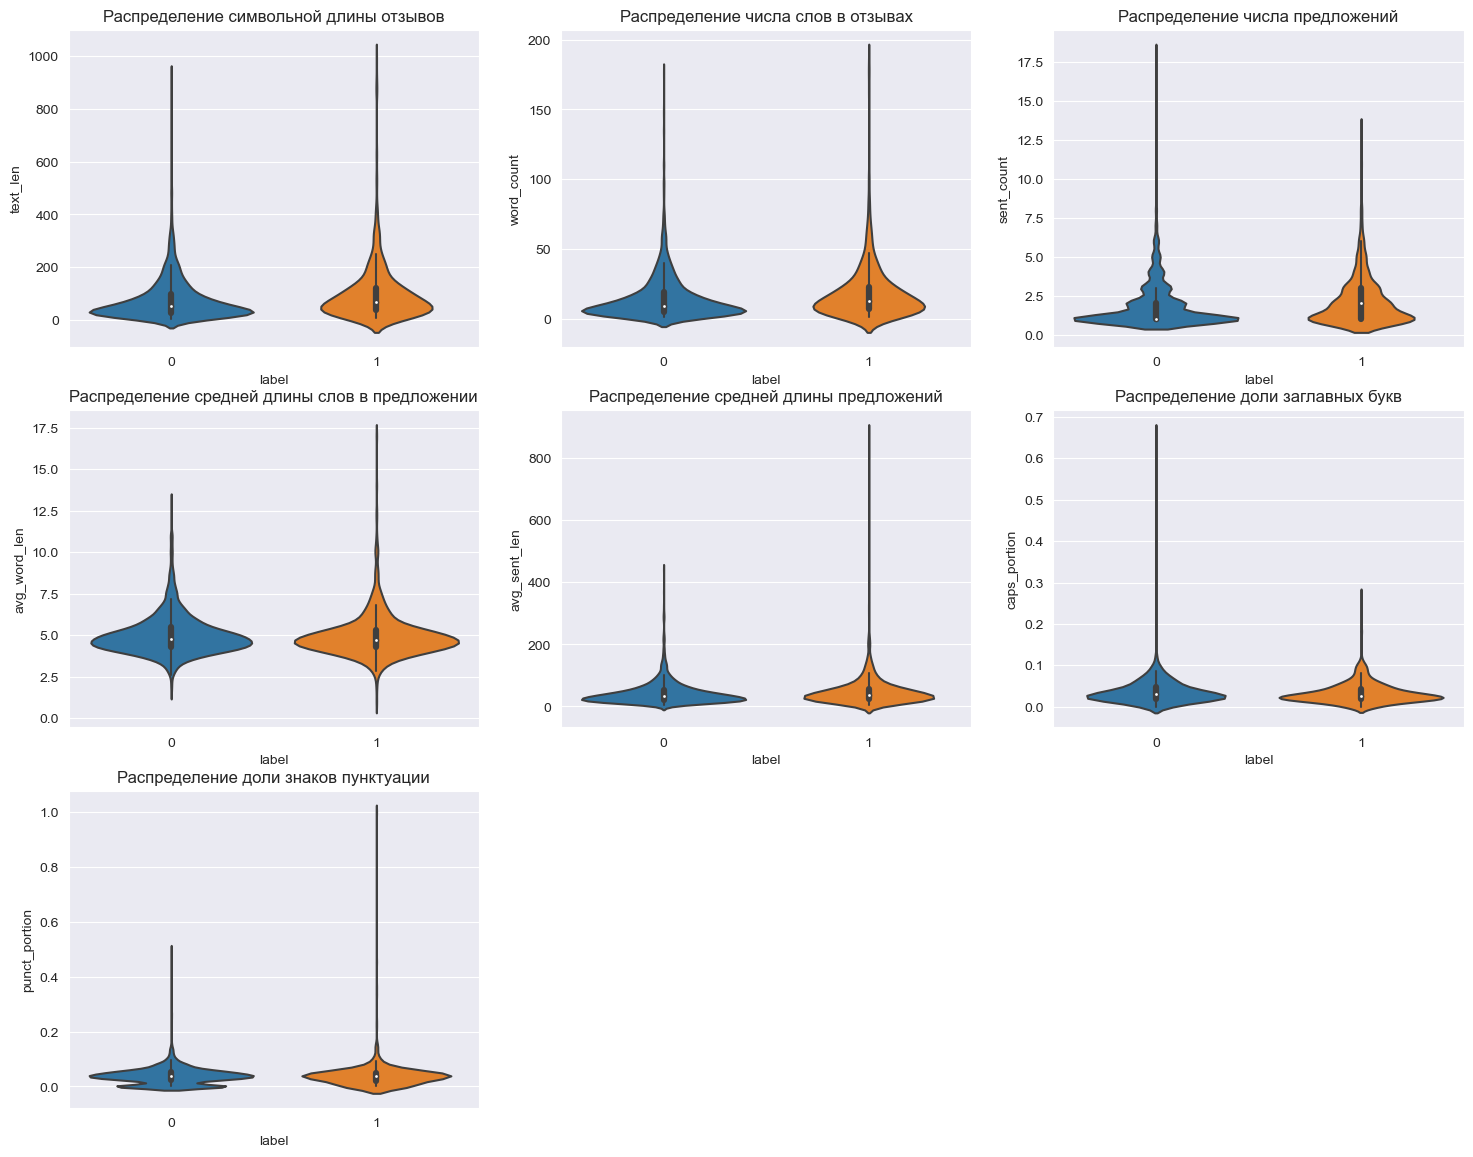

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(18, 14))
sns.violinplot(data=df, x='label', y='text_len', ax=ax[0][0])
ax[0][0].set_title('Распределение символьной длины отзывов')

sns.violinplot(data=df, x='label', y='word_count', ax=ax[0][1])
ax[0][1].set_title('Распределение числа слов в отзывах')

sns.violinplot(data=df, x='label', y='sent_count', ax=ax[0][2], bins=15)
ax[0][2].set_title('Распределение числа предложений')

sns.violinplot(data=df, x='label', y='avg_word_len', ax=ax[1][0])
ax[1][0].set_title('Распределение средней длины слов в предложении')

sns.violinplot(data=df, x='label', y='avg_sent_len', ax=ax[1][1])
ax[1][1].set_title('Распределение средней длины предложений')

sns.violinplot(data=df, x='label', y='caps_portion', ax=ax[1][2])
ax[1][2].set_title('Распределение доли заглавных букв')

sns.violinplot(data=df, x='label', y='punct_portion', ax=ax[2][0])
ax[2][0].set_title('Распределение доли знаков пунктуации')

# sns.violinplot(data=df, x='label', y='emoji_portion', ax=ax[2][1])
# ax[2][1].set_title('Распределение доли смайликов')

ax[2][1].axis('off')
ax[2][2].axis('off')

plt.show()

In [26]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 3))
# box_plt(df, 'text_len', axs[0])
# box_plt(df, 'word_count', axs[1])
        
# fig.subplots_adjust(wspace=0.3)
# plt.show()

### Определим наличие дубликатов

In [25]:
df.text.describe()

count               3123
unique              3078
top       Отличный товар
freq                  11
Name: text, dtype: object

Тексты отзывов не являются уникальными

Небольшое замечание: заметил, что для самого частовстречаемого текста ("Отличный товар") в 2 случаях из 11 отзывы являются фейковыми, также видел несколько отзывов, которые состояли только из смайликов с большими пальцами, но они тоже имели разные метки, соответственно, можно сделать вывод, что текст отзыва, скорее всего, не является определяющим фактором того, вляется ли отзыв фейковым, поэтому нужно учитывать остальные фичи.

**Проверим, есть ли полные дубликаты (т.е. полное совпадение строк датафрейма)**

In [26]:
df[df.duplicated(keep=False)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,...,label,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion,punct_portion,f9,f10
45,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.80315,10,3,5.0,...,0,136,29,5,4.103448,26.4,0.036765,0.073529,0.3,0.685039
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.80315,10,3,5.0,...,0,136,29,5,4.103448,26.4,0.036765,0.073529,0.3,0.685039


Удалим вторую из двух совпадающих строчек

In [27]:
df = df.drop_duplicates()

Также есть два наблюдения, где один и тот же пользователь написал одинаковый текст для разных товаров одного продавца. Кажется, что удалять смысла не имеет.

In [28]:
df[df[['id1', 'text']].duplicated(keep=False)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,...,label,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion,punct_portion,f9,f10
2797,3884959853494955383,2378932839265966503,9034398454034589390,Внукам нравится!,44,31,4.909091,174,20,4.919540,...,0,16,3,1,5.0,16.0,0.0625,0.0625,0.114943,0.704545
2831,3884959853494955383,12021259612890125721,9034398454034589390,Внукам нравится!,44,31,4.909091,490,55,4.804082,...,0,16,3,1,5.0,16.0,0.0625,0.0625,0.112245,0.704545


Проверим, нет ли ситуации, когда один пользователь оставил более одного отзыва какому-то товару.

In [29]:
df[df[['id1', 'id2']].duplicated(keep=False)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,...,label,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion,punct_portion,f9,f10


### Обработка выбросов

Построим ящики с усами для числовых признаков, но исключим из рассмотрения фичи с оценками (f3 и f6), для них удаление выбросов производить не будем

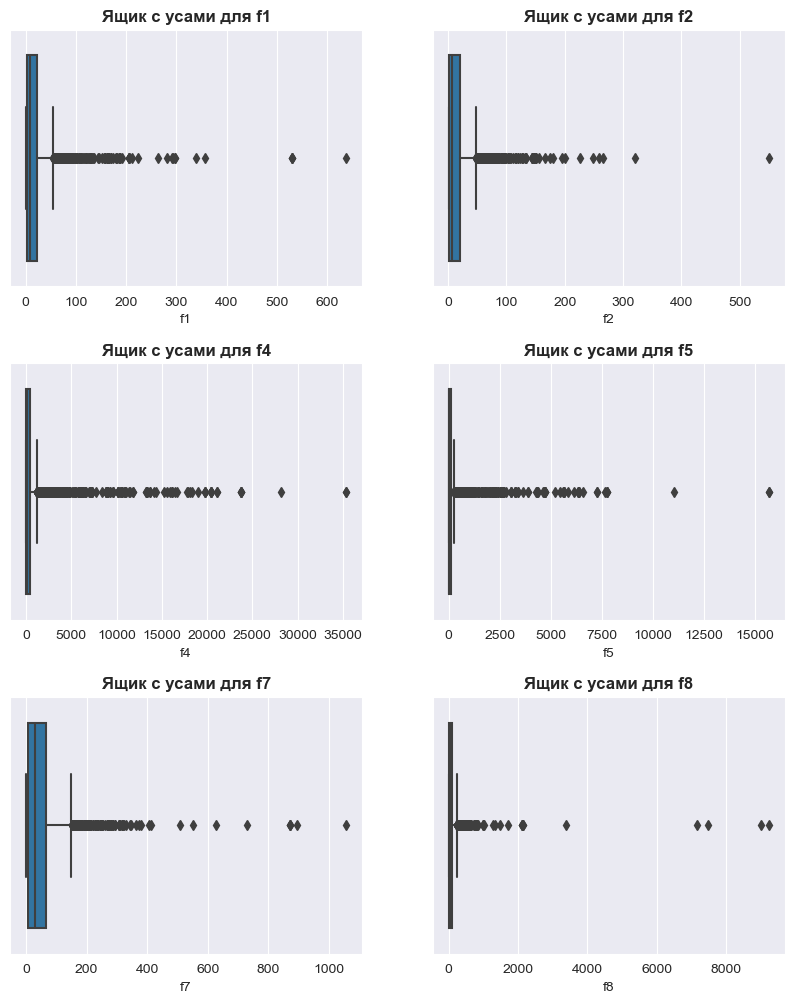

In [32]:
def box_plt(df, col_name, ax):
    sns.boxplot(x=col_name, data=df, ax=ax)
    ax.set_title(f'Ящик с усами для {col_name}', 
                 fontsize=12, weight='bold')
    
f_cols1 = ['f' + str(i) for i in range(1, 9) if i not in (3, 6)]
plt_arr = np.reshape(f_cols1, (3, 2))

fig, axs = plt.subplots(3, 2, figsize=(10, 12))
for i in range(3):
    for j in range(2):
        cur_col = plt_arr[i][j]
        box_plt(df, cur_col, axs[i][j])
        
fig.subplots_adjust(hspace=0.3)
plt.show()

In [40]:
df_copy = df.copy()

In [41]:
for col in f_cols1:
    print(col, ':')
    q1 = df_copy[col].quantile(0.25)
    q3 = df_copy[col].quantile(0.75)
    iqr = q3 - q1
    outliers = (df_copy[col] < (q1 - 1.5 * iqr)) | (df_copy[col] > (q3 + 1.5 * iqr))
    print(f'Нижний порог = {q1 - 1.5 * iqr}, верхний = {q3 + 1.5 * iqr}')
    print(f'Найдено {outliers.sum()} выбросов')
    print(f'Среди них {df_copy[outliers].label.sum()} фейковых')
    if input('Удалить выбросы? (y/n) ') == 'y':
        if input('Изменить пороги? (y/n) ') == 'y':
            # thres_low = int(input('Нижний порог: '))
            thres_up = int(input('Верхний порог: '))
            outliers = (df_copy[col] < thres_low) | (df_copy[col] > thres_up)
            print(f'Найдено {outliers.sum()} выбросов')
            print(f'Среди них {df_copy[outliers].label.sum()} фейковых')
            # df_copy = df_copy[(df_copy[col] >= thres_low) & (df_copy[col] <= thres_up)]
            if input('Удалить выбросы? (y/n) ') == 'y':
                df_copy = df_copy[~outliers]        
        else:
            df_copy = df_copy[~outliers]

f1 :
Нижний порог = -29.5, верхний = 54.5
Найдено 249 выбросов
Среди них 56 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f2 :
Нижний порог = -19.0, верхний = 37.0
Найдено 128 выбросов
Среди них 17 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f4 :
Нижний порог = -692.5, верхний = 1223.5
Найдено 373 выбросов
Среди них 126 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f5 :
Нижний порог = -76.0, верхний = 140.0
Найдено 259 выбросов
Среди них 81 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f7 :
Нижний порог = -60.0, верхний = 116.0
Найдено 100 выбросов
Среди них 22 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f8 :
Нижний порог = -87.0, верхний = 169.0
Найдено 78 выбросов
Среди них 33 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n


In [42]:
df_copy.shape[0]

1935

In [43]:
df_copy.label.mean()

0.2532299741602067

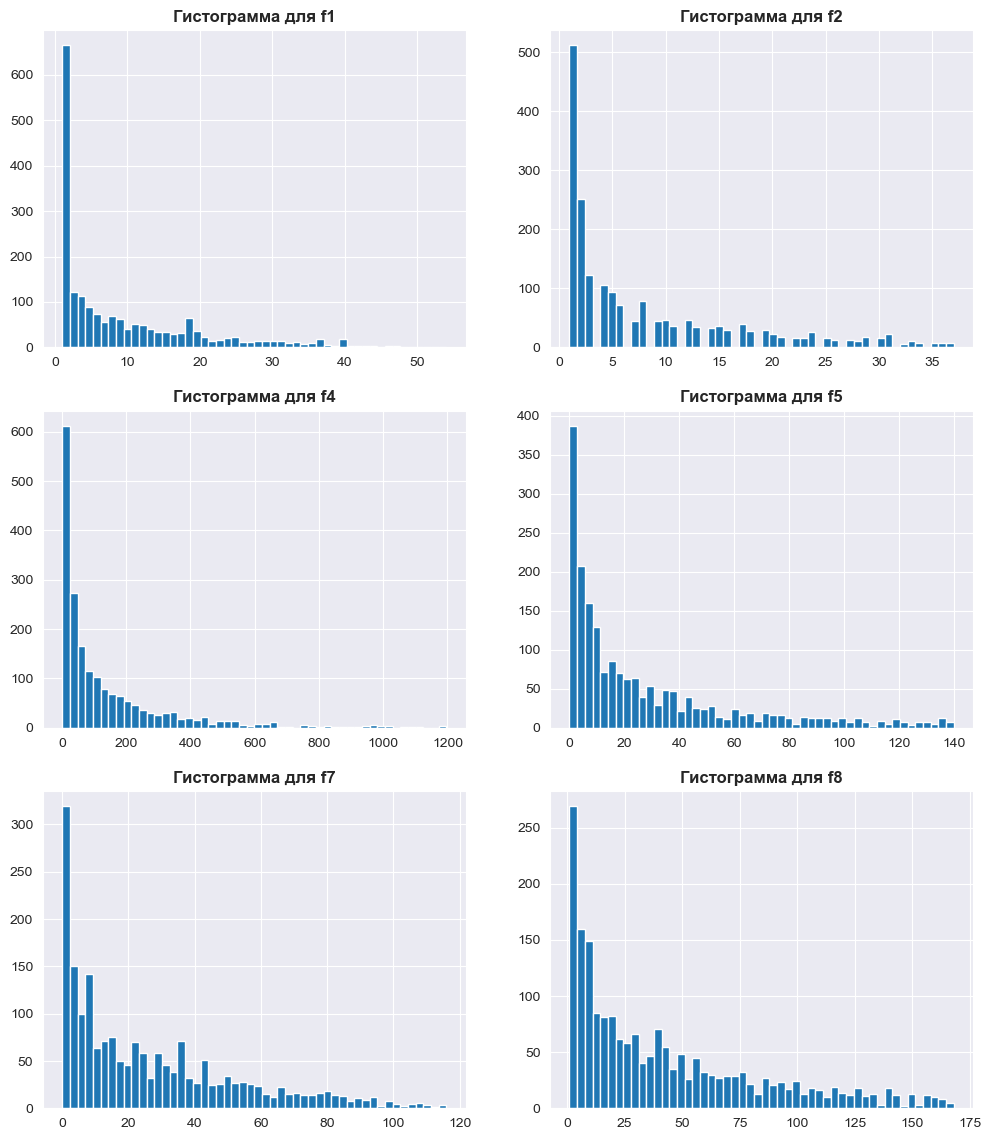

In [44]:
plt_arr = np.reshape(f_cols1, (3, 2))

fig, axs = plt.subplots(3, 2, figsize=(12, 14))
for i in range(3):
    for j in range(2):
        cur_col = plt_arr[i][j]
        df_copy[cur_col].hist(ax=axs[i][j], bins=50)
        axs[i][j].set_title(f'Гистограмма для {cur_col}', weight='bold')
plt.show()

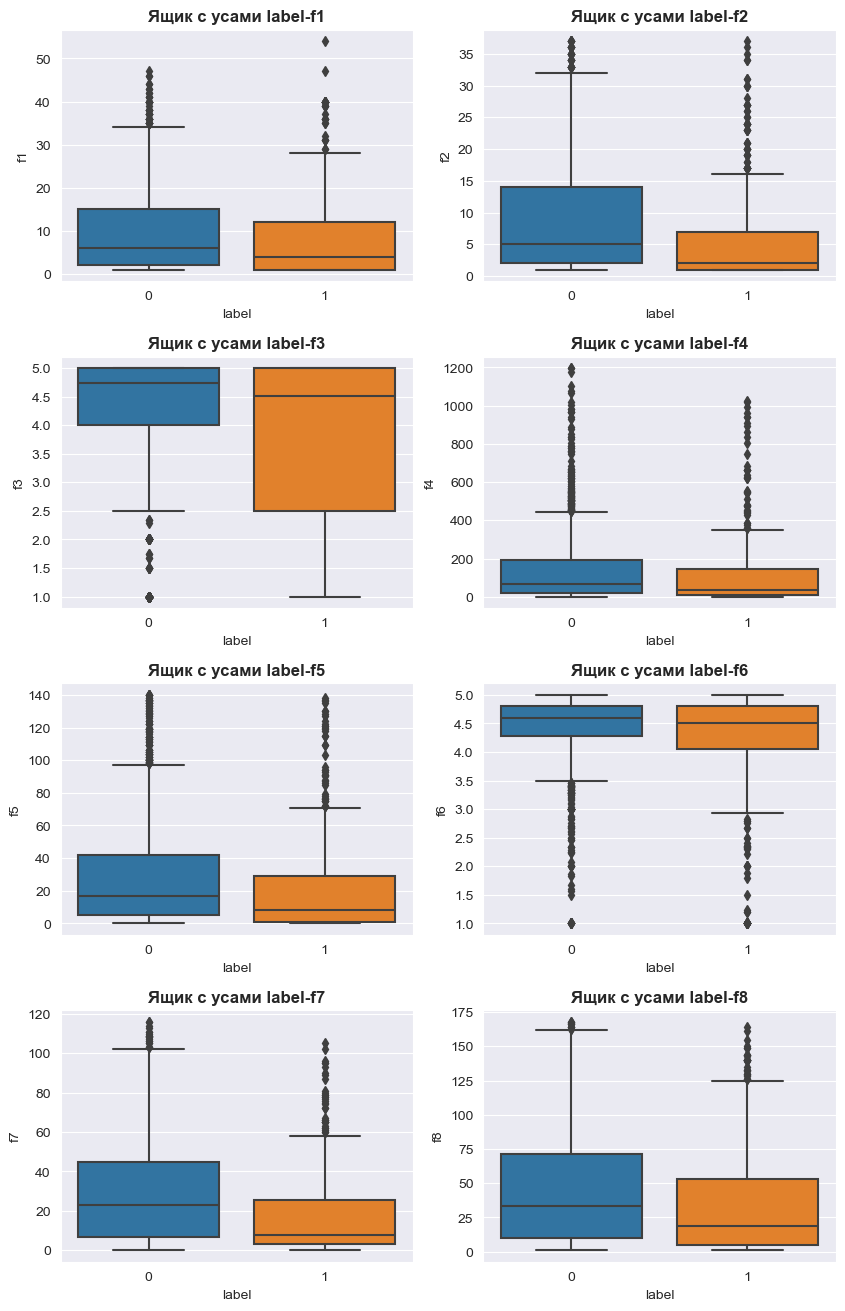

In [45]:
def box_plt(df, col_name, ax):
    sns.boxplot(x='label', y=col_name, data=df, ax=ax)
    ax.set_title(f'Ящик с усами label-{col_name}', 
                 fontsize=12, weight='bold')
    
fig, axs = plt.subplots(4, 2, figsize=(10, 16))
plt_arr = np.reshape(f_cols, (4, 2))
for i in range(4):
    for j in range(2):
        cur_col = plt_arr[i][j]
        box_plt(df_copy, cur_col, axs[i][j])
        
fig.subplots_adjust(hspace=0.3)
plt.show()

## Предобработка текстов

In [30]:
m = MorphAnalyzer()

In [31]:
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [32]:
# nltk.download('stopwords')  # скачаем стоп-слова для русского языка
print(stopwords.words('russian'))
stop = stopwords.words('russian') + list(punctuation)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [36]:
# spell = SpellChecker(language='ru')
# spell.correction('крута')
spell = Speller('ru', only_replacements=True)

In [33]:
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def correction_and_filter(s, stop_w):
    if s not in stop_w and len(s) > 2:
        corrected = spell.correction(s)
        if corrected is not None:
            if corrected not in stop_w and len(corrected) > 2:
                return corrected    
        

def preprocess_text(text, stop_w=stop, tokenizer=word_tokenize):  
    """функция предобработки текста"""
    # удаляем все, кроме букв кириллицы
    text = re.sub('[^А-Яа-яёЁ\s]', ' ', text)
#     text = spell(text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    text = tokenizer(text.lower(), language='russian')
#     text = [correction_and_filter(w, stop_w) for w in text if correction_and_filter(w, stop_w) is not None] # list(map(correction, text))
    text = [w for w in text if (w.replace('ё', 'е') not in stop_w) and (len(w) > 2)]
    text = lemmatize_text(text)
    return ' '.join(text)

In [34]:
tqdm.pandas()
df['clear_text'] = df.text.progress_apply(preprocess_text)

100%|█████████████████████████████████████████████████████████████████████████████| 3122/3122 [00:08<00:00, 349.21it/s]


In [35]:
df[['text', 'clear_text']].head(10)

,text,clear_text
0,"Хотела купить на замену старых,по итогу эти у...",хотеть купить замена старый итог ужаснотупой у...
1,Запах по сравнению с обычным DOVE никакой. Оно...,запах сравнение обычный никакой оно парфюмиров...
2,"Кабель подошёл, хорошо работает.",кабель подойти работать
3,"Восторг! Очень приятный аромат, держится долго...",восторг очень приятный аромат держаться долго ...
4,Визуально все хорошо. Не пробовали. Купили в п...,визуально пробовать купить подарок
5,"Коробка в состоянии,, прошла Афган,,! Гладкая ...",коробка состояние пройти афган гладкий кожа но...
6,Джинсы хорошие качество отличное но дороговаты...,джинсы хороший качество отличный дороговатый м...
7,Хорошее качество,хороший качество
8,"Камеры не закрывает, камеры в ровень с чехлом",камера закрывать камера ровеня чехол
9,Юлия не могли бы Вы проверить стеганку которую...,юлия мочь проверить стёганка который вернуть к...


Есть небольшая проблема, состоящая в том, что для нескольких отзывов мы из-за такой очистки, по сути, совсем лишились текста отзыва. Также есть проблема, связанная с опечатками

In [36]:
df[(df.clear_text.str.split().str.len() == 0)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,...,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion,punct_portion,f9,f10,clear_text
23,14932418852539196783,11594206611029735520,5576082564072164535,︎ ︎ ︎ ︎ ︎ ︎,8,7,5.000000,96,27,4.520833,...,11,6,1,1.000000,11.0,0.000000,0.000000,0.281250,0.875000,
369,8816573192000644470,5561072876759097566,7279234113731486608,Ок ок ок ок,7,7,4.428571,23,2,4.739130,...,11,4,1,2.000000,11.0,0.090909,0.000000,0.086957,1.000000,
408,7228372016730991648,5850695483357674592,8160404367092487937,__________,2,2,2.500000,27,3,4.111111,...,10,1,1,10.000000,10.0,0.000000,1.000000,0.111111,1.000000,
637,14533498944280804100,11860455876991826814,15053676552810216566,👍👍👍👍👍👍,13,13,4.846154,881,175,4.611805,...,6,1,1,6.000000,6.0,0.000000,0.000000,0.198638,1.000000,
751,10749861286048421051,14949176600961148554,8223254633971568382,Все хорошо,29,27,4.862069,27,5,4.518519,...,10,2,1,4.500000,10.0,0.100000,0.000000,0.185185,0.931034,
897,16003434369235304523,14926672264371803806,8223254633971568382,Всё хорошо.,18,18,4.777778,11,0,4.727273,...,11,3,1,3.333333,11.0,0.090909,0.090909,0.000000,1.000000,
914,9158133609663457546,11023721191884698213,13057272459692676590,Хорошо но не тот,1,1,5.000000,198,68,4.156566,...,16,4,1,3.250000,16.0,0.062500,0.000000,0.343434,1.000000,
1218,18020901957991569865,11775626371433002033,17776117386538683712,👌👍🏼👍🏼👍🏼👍🏼,6,6,5.000000,17,1,4.235294,...,9,1,1,9.000000,9.0,0.000000,0.000000,0.058824,1.000000,
1298,15376744332096648284,6268099669634872571,6836784353719029392,Всё хорошо ...,4,4,5.000000,48,4,4.395833,...,14,3,1,4.000000,14.0,0.071429,0.214286,0.083333,1.000000,
1374,7542702795411835022,9749876112909188500,7249931646404503757,Всё хорошо,16,16,4.750000,328,58,4.649390,...,10,2,1,4.500000,10.0,0.100000,0.000000,0.176829,1.000000,


## Перейдем к обучению моделей

In [37]:
def cv_log_results(model, X, y, cv=10):
    cv_scores = cross_val_score(model, X, y, scoring='f1', cv=cv)
    return cv_scores.mean(), cv_scores.std()

In [38]:
def print_metrics(model, X_train, y_train, X_test, 
                  y_test, config_name, cv=True):
    '''
    Удобная функция для вывода метрик.
    '''
    train_dct, test_dct = {}, {} 
    dct_lst = [train_dct, test_dct]
    pred_train, pred_test = model.predict(X_train), model.predict(X_test)
    probs_train = model.predict_proba(X_train)[:, 1]
    probs_test = model.predict_proba(X_test)[:, 1]
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score
    }
    for m in metrics:
        for i, cur_set in enumerate(zip([y_train, y_test], 
                                     [pred_train, pred_test])):
            dct_lst[i][m] = metrics[m](*cur_set)
            
    res_df = pd.DataFrame({'train': train_dct, 'test': test_dct}).T
    res_df['roc_auc'] = [
        roc_auc_score(y_train, probs_train),
        roc_auc_score(y_test, probs_test),
    ]
#     p1, r1, t1 = precision_recall_curve(y_train, probs_train)
#     p3, r3, t3 = precision_recall_curve(y_test, probs_test)
#     res_df['pr_auc'] = [auc(r1, p1), auc(r3, p3)]
    if cv == True:
        cv_mean, cv_std = cv_log_results(model, X_train, y_train)
        res_df.loc['train', 'cv'] = str(round(cv_mean, 2)) + '$\pm$' + str(round(cv_std, 2))
    res_df = res_df.round(3)
    res_df.index = pd.MultiIndex.from_tuples(zip([config_name] * 2, res_df.index), 
                                             names=['configuration', 'set'])
    display(res_df)
    return res_df

In [39]:
def fit_and_metrics(model, X_train, y_train, X_test, y_test,
                    config_name, cv=True):
    model.fit(X_train, y_train)
    res_df = print_metrics(model, X_train, y_train,
                           X_test, y_test, config_name, cv)
    return model, res_df

### В качестве слабого бейзлайна возьмем модель на признаках f1-f8

In [40]:
X, y = df.loc[:, 'f1': 'f8'], df.label

In [41]:
X.head(3)

,f1,f2,f3,f4,f5,f6,f7,f8
0,1,1,1.0,11,13,4.272727,18,36
1,10,6,2.7,46,4,4.434783,90,109
2,4,4,4.0,14,0,4.500000,4,6


## L3. Разбиение на train/test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [43]:
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), X_train.columns)  
])

X_train_transf = column_transformer.fit_transform(X_train)
X_test_transf = column_transformer.transform(X_test)

## L4. Бейзлайн

In [44]:
dummy_base = DummyClassifier(strategy='constant', constant=1)
dummy_base, res_df_dummy_base = fit_and_metrics(
    dummy_base, X_train_transf, y_train, 
    X_test_transf, y_test, 'dummy_baseline'
)

accuracy  precision  recall     f1  roc_auc  \
configuration  set                                                  
dummy_baseline train     0.264      0.264     1.0  0.418      0.5   
               test      0.264      0.264     1.0  0.418      0.5   

                                cv  
configuration  set                  
dummy_baseline train  0.42$\pm$0.0  
               test            NaN

In [45]:
simple_base = SVC(probability=True, random_state=42, class_weight='balanced')
simple_base, res_df_simple_base = fit_and_metrics(
    simple_base, X_train_transf, y_train, 
    X_test_transf, y_test, 'simple_baseline'
)

accuracy  precision  recall     f1  roc_auc  \
configuration   set                                                  
simple_baseline train     0.697      0.448   0.633  0.525    0.727   
                test      0.682      0.422   0.558  0.480    0.732   

                                 cv  
configuration   set                  
simple_baseline train  0.5$\pm$0.04  
                test            NaN

### Обучим модель без текстовых фичей

**Разбиение и нормировка для случая без использования фичей punct_portion, f9, f10**

In [46]:
X, y = df.drop(columns=['punct_portion', 'f9', 'f10', 'label']), df.label

In [47]:
X = X.drop(columns=['id1', 'id2', 'id3', 'text', 'clear_text'])

In [48]:
X.head(3)

,f1,f2,f3,f4,f5,f6,f7,f8,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion
0,1,1,1.0,11,13,4.272727,18,36,96,21,1,3.857143,96.000000,0.010417
1,10,6,2.7,46,4,4.434783,90,109,99,17,3,5.000000,32.333333,0.070707
2,4,4,4.0,14,0,4.500000,4,6,32,6,1,4.833333,32.000000,0.031250


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
print(len(y_train), 'объектов в обучающей выборке')
print(len(y_test), 'объектов в тестовой выборке')

2497 объектов в обучающей выборке
625 объектов в тестовой выборке


In [50]:
numeric = list(X.loc[:, :'caps_portion'].columns)
print(numeric)

column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), numeric)  
], remainder='passthrough')

X_train_transf = column_transformer.fit_transform(X_train)
X_test_transf = column_transformer.transform(X_test)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'text_len', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len', 'caps_portion']


**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [51]:
X1, y = df.drop(columns=['label']), df.label

In [52]:
X1 = X1.drop(columns=['id1', 'id2', 'id3', 'text', 'clear_text'])

In [53]:
X1.head(3)

,f1,f2,f3,f4,f5,f6,f7,f8,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion,punct_portion,f9,f10
0,1,1,1.0,11,13,4.272727,18,36,96,21,1,3.857143,96.000000,0.010417,0.052083,1.181818,1.0
1,10,6,2.7,46,4,4.434783,90,109,99,17,3,5.000000,32.333333,0.070707,0.020202,0.086957,0.6
2,4,4,4.0,14,0,4.500000,4,6,32,6,1,4.833333,32.000000,0.031250,0.062500,0.000000,1.0


In [54]:
X_train1, X_test1, y_train, y_test = train_test_split(X1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

In [55]:
numeric = list(X1.loc[:, :'f10'].columns)
print(numeric)

column_transformer1 = ColumnTransformer([
    ('scaler', StandardScaler(), numeric)  
], remainder='passthrough')

X_train_transf1 = column_transformer1.fit_transform(X_train1)
X_test_transf1 = column_transformer1.transform(X_test1)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'text_len', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len', 'caps_portion', 'punct_portion', 'f9', 'f10']


**Обучение моделей**

In [56]:
lr_no_text = LogisticRegression(max_iter=5000, random_state=42, 
                                class_weight='balanced')
lr_no_text, res_df_lr_no_text = fit_and_metrics(lr_no_text, X_train_transf, y_train, 
                                                X_test_transf, y_test, 'lr_no_text')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_no_text    train     0.694      0.438   0.555  0.490    0.708   
              test      0.707      0.456   0.570  0.507    0.742   

                                cv  
configuration set                   
lr_no_text    train  0.48$\pm$0.03  
              test             NaN

In [60]:
# с добавлением доп. фичей (только punct_count)
lr_no_text1 = LogisticRegression(max_iter=5000, random_state=42, 
                                class_weight='balanced')
lr_no_text1, res_df_lr_no_text1 = fit_and_metrics(lr_no_text, X_train_transf1, y_train,
                                                  X_test_transf1, y_test, 'lr_no_text1') 

accuracy  precision  recall     f1  roc_auc
configuration set                                               
lr_no_text1   train     0.695      0.439   0.556  0.491    0.708
              test      0.714      0.467   0.594  0.523    0.737

In [57]:
# с добавлением доп. фичей
lr_no_text1 = LogisticRegression(max_iter=5000, random_state=42, 
                                class_weight='balanced')
lr_no_text1, res_df_lr_no_text1 = fit_and_metrics(lr_no_text, X_train_transf1, y_train,
                                                  X_test_transf1, y_test, 'lr_no_text1') 

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_no_text1   train     0.712      0.462   0.545  0.500    0.723   
              test      0.726      0.484   0.564  0.521    0.739   

                                cv  
configuration set                   
lr_no_text1   train  0.49$\pm$0.05  
              test             NaN

In [58]:
def grid_search(model, X, y, params, scoring='f1', cv=None):    
    gscv = GridSearchCV(model, params, scoring=scoring, cv=cv, n_jobs=-1)
    gscv.fit(X, y)
    print('Best score: %.5f' % gscv.best_score_)
    print('Best params:', gscv.best_params_)
    return gscv

In [59]:
params = {'C': np.logspace(-3, 1, 20), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs = grid_search(model, X_train_transf, y_train, params, cv=10)

Best score: 0.48648
Best params: {'C': 6.158482110660261, 'solver': 'saga'}


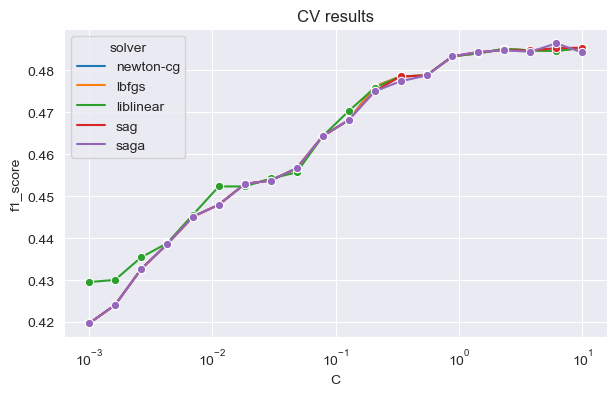

In [60]:
cv_res_df = pd.DataFrame(lr_gs.cv_results_['params'])
cv_res_df['f1_score'] = lr_gs.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df, x='C', y='f1_score', hue='solver', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [60]:
lr_no_text_cv = LogisticRegression(max_iter=5000, random_state=42, 
                                   class_weight='balanced', **lr_gs.best_params_)
lr_no_text_cv, res_df_lr_no_text_cv = fit_and_metrics(lr_no_text_cv, X_train_transf, y_train, 
                                                      X_test_transf, y_test, 'lr_no_text_cv')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_no_text_cv train     0.695      0.439   0.556  0.491    0.709   
              test      0.715      0.468   0.576  0.516    0.745   

                                cv  
configuration set                   
lr_no_text_cv train  0.49$\pm$0.04  
              test             NaN

In [61]:
def cv_results(model, X, y, cv=10):
    cv_scores = cross_val_score(model, X, y, scoring='f1', cv=cv)  # по умолчанию StratifiedKFold
    print('CV-scores:', ' | '.join(map(lambda x: str(round(x, 2)), cv_scores)))
    print(f'CV results on {cv} folds: mean=%.4f, std=%.3f' % (cv_scores.mean(), cv_scores.std()))

In [149]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced', **lr_gs.best_params_), 
           X_train_transf, y_train)

CV-scores: 0.5 | 0.54 | 0.45 | 0.49 | 0.48 | 0.49 | 0.54 | 0.5 | 0.43 | 0.45
CV results on 10 folds: mean=0.4865, std=0.035


**Подведем итог по моделям без текстов**

In [62]:
no_text_final = pd.concat([res_df_dummy_base, res_df_simple_base,
                           res_df_lr_no_text, res_df_lr_no_text_cv,
                           res_df_lr_no_text1])
no_text_final

accuracy  precision  recall     f1  roc_auc  \
configuration   set                                                  
dummy_baseline  train     0.264      0.264   1.000  0.418    0.500   
                test      0.264      0.264   1.000  0.418    0.500   
simple_baseline train     0.697      0.448   0.633  0.525    0.727   
                test      0.682      0.422   0.558  0.480    0.732   
lr_no_text      train     0.694      0.438   0.555  0.490    0.708   
                test      0.707      0.456   0.570  0.507    0.742   
lr_no_text_cv   train     0.695      0.439   0.556  0.491    0.709   
                test      0.715      0.468   0.576  0.516    0.745   
lr_no_text1     train     0.712      0.462   0.545  0.500    0.723   
                test      0.726      0.484   0.564  0.521    0.739   

                                  cv  
configuration   set                   
dummy_baseline  train   0.42$\pm$0.0  
                test             NaN  
simple_baseline train   0.5$\pm$0.04  
                test             NaN  
lr_no_text      train  0.48$\pm$0.03  
                test             NaN  
lr_no_text_cv   train  0.49$\pm$0.04  
                test             NaN  
lr_no_text1     train  0.49$\pm$0.05  
                test             NaN

In [152]:
feat_names = column_transformer1.transformers_[0][2]
cols_coefs = list(zip(feat_names, lr_no_text1.coef_[0]))
cols_coefs_sorted = sorted(cols_coefs, key=lambda x: abs(x[1]), reverse=True) 

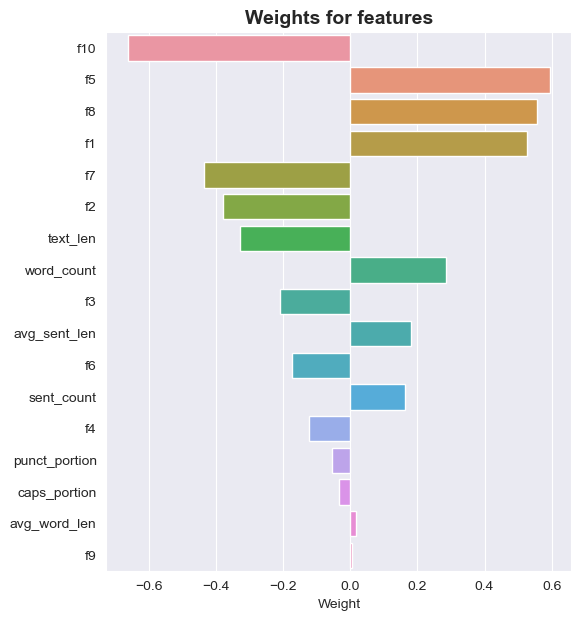

In [153]:
def show_weights(features_weights, linear=True, num=30):
    plt.figure(figsize=(6, 7))
    weights = [x[1] for x in features_weights[:num]]
    features = [x[0] for x in features_weights[:num]]
    sns.barplot(y=features, x=weights)
    plt.xlabel('Weight')
    plt.title('Weights for features', weight='bold', fontsize=14)
    plt.show()
    return features

feat = show_weights(cols_coefs_sorted)

### Bag-of-words

In [63]:
vectorizer = CountVectorizer(preprocessor=preprocess_text, tokenizer=word_tokenize,
                             min_df=4, token_pattern='[А-Яа-яёЁ\s]+')
bow = vectorizer.fit_transform(df.clear_text)
bow

<3122x1075 sparse matrix of type '<class 'numpy.int64'>'
	with 19455 stored elements in Compressed Sparse Row format>

In [64]:
bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out(),
                      index=df.index)
# bow_df.head(3)

**Разбиение и нормировка для случая без использования фичей punct_portion, f9, f10**

In [65]:
X_bow = pd.concat([X, bow_df], axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [67]:
X_train_transf = column_transformer.fit_transform(X_train)
X_test_transf = column_transformer.transform(X_test)

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [68]:
X_bow1 = pd.concat([X1, bow_df], axis=1)

In [69]:
X_train1, X_test1, y_train, y_test = train_test_split(X_bow1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

In [70]:
X_train_transf1 = column_transformer1.fit_transform(X_train1)
X_test_transf1 = column_transformer1.transform(X_test1)

**Обучение моделей**

In [71]:
lr_bow = LogisticRegression(max_iter=5000, random_state=42, 
                            class_weight='balanced')
lr_bow, res_df_lr_bow = fit_and_metrics(lr_bow, X_train_transf, y_train, 
                                        X_test_transf, y_test, 'lr_bow')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_bow        train     0.859      0.711   0.785  0.746    0.918   
              test      0.675      0.402   0.473  0.435    0.636   

                                cv  
configuration set                   
lr_bow        train  0.45$\pm$0.03  
              test             NaN

In [60]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced'), 
           X_train_transf, y_train)

CV-scores: 0.44 | 0.49 | 0.44 | 0.45 | 0.46 | 0.51 | 0.43 | 0.48 | 0.38 | 0.47
CV results on 10 folds: mean=0.4538, std=0.032


In [72]:
lr_bow1 = LogisticRegression(max_iter=5000, random_state=42, 
                             class_weight='balanced')
lr_bow1, res_df_lr_bow1 = fit_and_metrics(lr_bow1, X_train_transf1, y_train, 
                                          X_test_transf1, y_test, 'lr_bow1')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_bow1       train     0.866      0.722   0.800  0.759    0.924   
              test      0.723      0.476   0.491  0.484    0.661   

                                cv  
configuration set                   
lr_bow1       train  0.49$\pm$0.04  
              test             NaN

In [77]:
params = {'C': np.logspace(-3, 1, 15), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_bow = grid_search(model, X_train_transf, y_train, params, cv=5)

Best score: 0.48054
Best params: {'C': 0.1, 'solver': 'lbfgs'}


In [175]:
params = {'C': np.logspace(-3, 1, 15), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_bow = grid_search(model, X_train_transf1, y_train, params, cv=5)

Best score: 0.50058
Best params: {'C': 0.19306977288832497, 'solver': 'liblinear'}


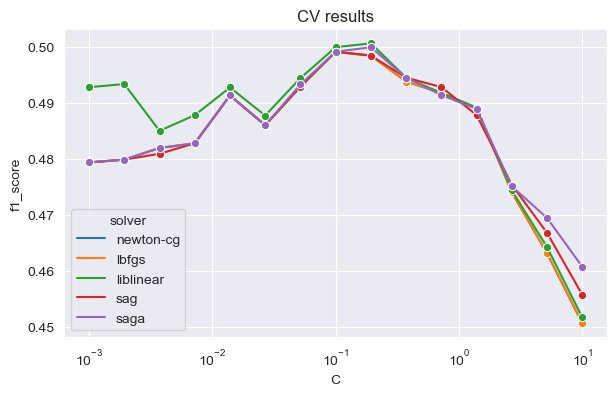

In [176]:
cv_res_df_bow = pd.DataFrame(lr_gs_bow.cv_results_['params'])
cv_res_df_bow['f1_score'] = lr_gs_bow.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_bow, x='C', y='f1_score', hue='solver', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [74]:
lr_bow_cv = LogisticRegression(max_iter=5000, random_state=42, 
                               class_weight='balanced', **lr_gs_bow.best_params_)
lr_bow_cv, res_df_lr_bow_cv = fit_and_metrics(lr_bow_cv, X_train_transf, y_train, 
                                              X_test_transf, y_test, 'lr_bow_cv')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_bow_cv     train     0.788      0.586   0.668  0.625    0.833   
              test      0.698      0.438   0.509  0.471    0.686   

                                cv  
configuration set                   
lr_bow_cv     train  0.47$\pm$0.03  
              test             NaN

In [73]:
lr_bow_cv1 = LogisticRegression(max_iter=5000, random_state=42, 
                               class_weight='balanced', **lr_gs_bow.best_params_)
lr_bow_cv1, res_df_lr_bow_cv1 = fit_and_metrics(lr_bow_cv1, X_train_transf1, y_train, 
                                                X_test_transf1, y_test, 'lr_bow_cv1')

accuracy  precision  recall     f1  roc_auc            cv
configuration set                                                             
lr_bow_cv1    train     0.823      0.650   0.712  0.680    0.872  0.5$\pm$0.05
              test      0.738      0.503   0.515  0.509    0.699           NaN

In [86]:
# с дефолтными параметрами был сильный оверфит, поэтому сразу увеличил регуляризацию
svm_bow = SVC(C=0.15, class_weight='balanced', probability=True, random_state=42)
svm_bow, res_df_svm_bow = fit_and_metrics(svm_bow, X_train_transf, y_train,
                                          X_test_transf, y_test, 'svm_bow', False)

accuracy  precision  recall     f1  roc_auc
configuration set                                               
svm_bow       train     0.658      0.408   0.645  0.500    0.735
              test      0.662      0.407   0.612  0.489    0.693

In [61]:
cv_results(SVC(C=0.15, class_weight='balanced', probability=True, random_state=42), 
           X_train_transf, y_train)

CV-scores: 0.47 | 0.46 | 0.47 | 0.45 | 0.46 | 0.43 | 0.49 | 0.45 | 0.5 | 0.45
CV results on 10 folds: mean=0.4627, std=0.020


In [74]:
svm_bow1 = SVC(C=0.15, class_weight='balanced', probability=True, random_state=42)
svm_bow1, res_df_svm_bow1 = fit_and_metrics(svm_bow1, X_train_transf1, y_train,
                                            X_test_transf1, y_test, 'svm_bow1', False)

accuracy  precision  recall     f1  roc_auc
configuration set                                               
svm_bow1      train     0.715      0.471   0.629  0.539    0.773
              test      0.701      0.447   0.558  0.496    0.750

In [83]:
params = {'C': np.linspace(0.05, 0.25, 5), 
          'kernel': ('linear', 'rbf')}
model = SVC(class_weight='balanced', probability=True, random_state=42)

svm_gs_bow = grid_search(model, X_train_transf, y_train, params, cv=5)

Best score: 0.47155
Best params: {'C': 0.3, 'kernel': 'linear'}


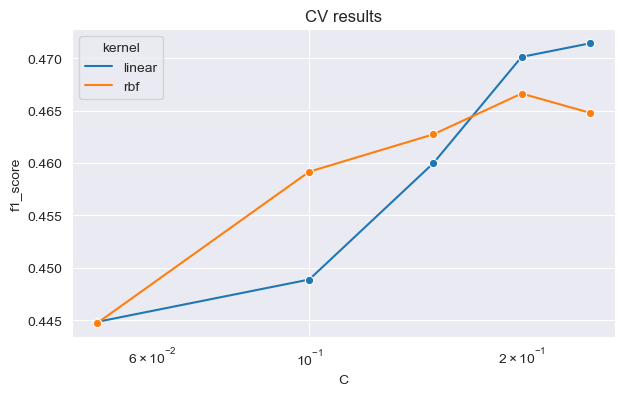

In [99]:
cv_res_df_bow1 = pd.DataFrame(svm_gs_bow.cv_results_['params'])
cv_res_df_bow1['f1_score'] = svm_gs_bow.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_bow1, x='C', y='f1_score', hue='kernel', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [75]:
svm_bow_cv = SVC(class_weight='balanced', probability=True, random_state=42, C=0.25)
svm_bow_cv, res_df_svm_bow_cv = fit_and_metrics(svm_bow_cv, X_train_transf, y_train,
                                                X_test_transf, y_test, 'svm_bow_cv', False)

accuracy  precision  recall     f1  roc_auc
configuration set                                               
svm_bow_cv    train     0.684      0.436   0.664  0.526    0.770
              test      0.670      0.416   0.612  0.495    0.703

In [62]:
cv_results(SVC(C=0.25, class_weight='balanced', probability=True, random_state=42), 
           X_train_transf, y_train)

CV-scores: 0.48 | 0.47 | 0.43 | 0.47 | 0.44 | 0.45 | 0.5 | 0.47 | 0.5 | 0.45
CV results on 10 folds: mean=0.4653, std=0.021


**Подведем итог по моделям, к. обучались с векторизацией текстов с помощью Bag-of-words**

In [76]:
bow_final = pd.concat([res_df_lr_bow1, res_df_lr_bow_cv1,
                       res_df_svm_bow1, res_df_svm_bow_cv])
bow_final

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_bow1       train     0.866      0.722   0.800  0.759    0.924   
              test      0.723      0.476   0.491  0.484    0.661   
lr_bow_cv1    train     0.823      0.650   0.712  0.680    0.872   
              test      0.738      0.503   0.515  0.509    0.699   
svm_bow1      train     0.715      0.471   0.629  0.539    0.773   
              test      0.701      0.447   0.558  0.496    0.750   
svm_bow_cv    train     0.684      0.436   0.664  0.526    0.770   
              test      0.670      0.416   0.612  0.495    0.703   

                                cv  
configuration set                   
lr_bow1       train  0.49$\pm$0.04  
              test             NaN  
lr_bow_cv1    train   0.5$\pm$0.05  
              test             NaN  
svm_bow1      train            NaN  
              test             NaN  
svm_bow_cv    train            NaN  
              test             NaN

### Теперь используем TF-IDF для векторизации текстов

In [77]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_text, tokenizer=word_tokenize,
                             min_df=4, token_pattern='[А-Яа-яёЁ\s]+')
tf_idf = vectorizer.fit_transform(df.clear_text)
tf_idf

<3122x1075 sparse matrix of type '<class 'numpy.float64'>'
	with 19455 stored elements in Compressed Sparse Row format>

In [78]:
tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names_out(),
                         index=df.index)
# tf_idf_df.head(3)

**Разбиение и нормировка для случая без использования фичей punct_portion, f9, f10**

In [79]:
X_idf = pd.concat([X, tf_idf_df], axis=1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_idf, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [81]:
X_train_transf = column_transformer.fit_transform(X_train)
X_test_transf = column_transformer.transform(X_test)

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [82]:
X_idf1 = pd.concat([X1, tf_idf_df], axis=1)

In [83]:
X_train1, X_test1, y_train, y_test = train_test_split(X_idf1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

In [84]:
X_train_transf1 = column_transformer1.fit_transform(X_train1)
X_test_transf1 = column_transformer1.transform(X_test1)

**Обучение моделей**

In [85]:
lr_idf1 = LogisticRegression(max_iter=5000, random_state=42,
                            class_weight='balanced')
lr_idf1, res_df_lr_idf1 = fit_and_metrics(lr_idf1, X_train_transf1, y_train, 
                                          X_test_transf1, y_test, 'lr_idf1')

accuracy  precision  recall     f1  roc_auc            cv
configuration set                                                             
lr_idf1       train     0.815      0.626   0.742  0.679    0.875  0.5$\pm$0.05
              test      0.730      0.489   0.533  0.510    0.711           NaN

In [95]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced'), 
           X_train_transf1, y_train)

CV-scores: 0.52 | 0.59 | 0.55 | 0.48 | 0.5 | 0.52 | 0.51 | 0.48 | 0.4 | 0.47
CV results on 10 folds: mean=0.5013, std=0.048


In [62]:
params = {'C': np.logspace(-3, 1, 15), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_idf = grid_search(model, X_train_transf, y_train, params, cv=5)

Best score: 0.49737
Best params: {'C': 0.7196856730011514, 'solver': 'sag'}


In [96]:
params = {'C': np.logspace(-3, 1, 15), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_idf = grid_search(model, X_train_transf1, y_train, params, cv=5)

Best score: 0.51012
Best params: {'C': 0.7196856730011514, 'solver': 'sag'}


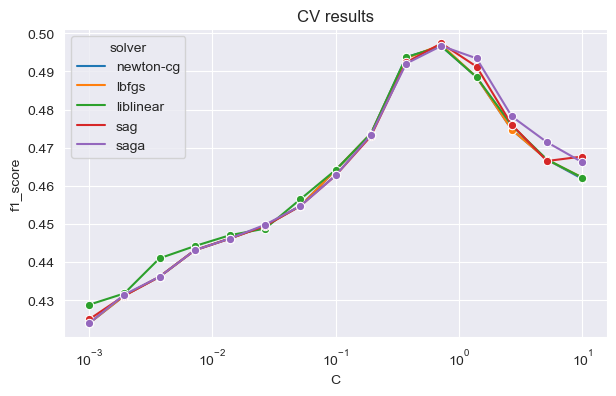

In [116]:
cv_res_df_idf = pd.DataFrame(lr_gs_idf.cv_results_['params'])
cv_res_df_idf['f1_score'] = lr_gs_idf.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_idf, x='C', y='f1_score', hue='solver', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

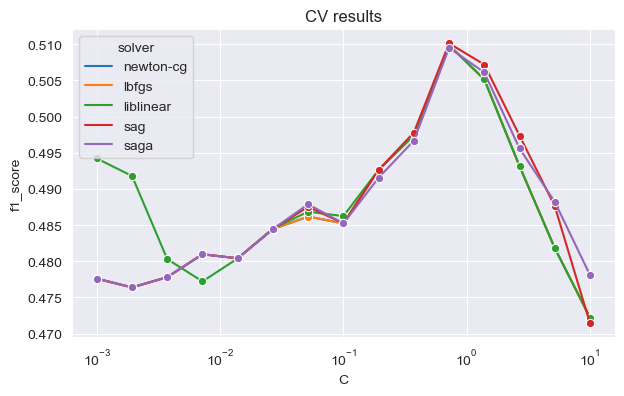

In [97]:
cv_res_df_idf = pd.DataFrame(lr_gs_idf.cv_results_['params'])
cv_res_df_idf['f1_score'] = lr_gs_idf.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_idf, x='C', y='f1_score', hue='solver', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [72]:
lr_idf_cv = LogisticRegression(max_iter=5000, random_state=42, 
                               class_weight='balanced', C=0.08)
lr_idf_cv, res_df_lr_idf_cv = fit_and_metrics(lr_idf_cv, X_train_transf, y_train,
                                              X_test_transf, y_test, 'lr_idf_cv')

accuracy  precision  recall     f1  roc_auc
configuration set                                               
lr_idf_cv     train     0.719      0.474   0.585  0.524    0.749
              test      0.715      0.468   0.582  0.519    0.728

In [74]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced', C=0.08), 
           X_train_transf, y_train)

CV-scores: 0.45 | 0.53 | 0.43 | 0.46 | 0.49 | 0.44 | 0.56 | 0.49 | 0.44 | 0.44
CV results on 10 folds: mean=0.4728, std=0.040


In [86]:
lr_idf_cv1 = LogisticRegression(max_iter=5000, random_state=42, 
                               class_weight='balanced', C=0.1)
lr_idf_cv1, res_df_lr_idf_cv1 = fit_and_metrics(lr_idf_cv1, X_train_transf1, y_train,
                                                X_test_transf1, y_test, 'lr_idf_cv1')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_idf_cv1    train     0.733      0.495   0.568  0.529    0.772   
              test      0.742      0.511   0.558  0.533    0.741   

                                cv  
configuration set                   
lr_idf_cv1    train  0.49$\pm$0.05  
              test             NaN

In [87]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced', C=0.1), 
           X_train_transf1, y_train)

CV-scores: 0.5 | 0.58 | 0.5 | 0.46 | 0.46 | 0.52 | 0.57 | 0.46 | 0.42 | 0.43
CV results on 10 folds: mean=0.4894, std=0.052


**Подведем итог по моделям, к. обучались с векторизацией текстов с помощью TF-IDF**

In [88]:
idf_final = pd.concat([res_df_lr_idf1, res_df_lr_idf_cv1])
idf_final

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_idf1       train     0.815      0.626   0.742  0.679    0.875   
              test      0.730      0.489   0.533  0.510    0.711   
lr_idf_cv1    train     0.733      0.495   0.568  0.529    0.772   
              test      0.742      0.511   0.558  0.533    0.741   

                                cv  
configuration set                   
lr_idf1       train   0.5$\pm$0.05  
              test             NaN  
lr_idf_cv1    train  0.49$\pm$0.05  
              test             NaN

### Теперь используем W2V для векторизации текстов

In [89]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [90]:
navec['товар'].shape

(300,)

In [91]:
corp_to_embeds = []
for review in df.clear_text:
    lst = [navec[w] for w in review.split() if w in navec]
    if len(lst) > 0:
        corp_to_embeds.append(np.mean(lst, axis=0))
    else:
        corp_to_embeds.append(np.zeros(300))

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [94]:
X_w2v = X.copy()
X_w2v['embeds'] = corp_to_embeds
embeds_df = X_w2v['embeds'].apply(pd.Series)
X_w2v = pd.concat([X_w2v, embeds_df], axis=1).drop(columns='embeds')
X_w2v.columns = X_w2v.columns.astype(str)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [96]:
X_train_transf = column_transformer.fit_transform(X_train)
X_test_transf = column_transformer.transform(X_test)

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [97]:
X_w2v1 = X1.copy()
X_w2v1['embeds'] = corp_to_embeds
embeds_df = X_w2v1['embeds'].apply(pd.Series)
X_w2v1 = pd.concat([X_w2v1, embeds_df], axis=1).drop(columns='embeds')
X_w2v1.columns = X_w2v1.columns.astype(str)

In [98]:
X_train1, X_test1, y_train, y_test = train_test_split(X_w2v1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

In [99]:
X_train_transf1 = column_transformer1.fit_transform(X_train1)
X_test_transf1 = column_transformer1.transform(X_test1)

**Обучение моделей**

In [100]:
lr_w2v = LogisticRegression(max_iter=5000, random_state=42, 
                            class_weight='balanced')
lr_w2v, res_df_lr_w2v = fit_and_metrics(lr_w2v, X_train_transf, y_train,
                                        X_test_transf, y_test, 'lr_w2v')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_w2v        train     0.726      0.488   0.715  0.580    0.802   
              test      0.645      0.380   0.545  0.448    0.675   

                                cv  
configuration set                   
lr_w2v        train  0.45$\pm$0.04  
              test             NaN

In [101]:
lr_w2v1 = LogisticRegression(max_iter=5000, random_state=42, 
                            class_weight='balanced')
lr_w2v1, res_df_lr_w2v1 = fit_and_metrics(lr_w2v1, X_train_transf1, y_train,
                                          X_test_transf1, y_test, 'lr_w2v1')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_w2v1       train     0.753      0.525   0.689  0.596    0.819   
              test      0.669      0.401   0.515  0.451    0.689   

                                cv  
configuration set                   
lr_w2v1       train  0.48$\pm$0.04  
              test             NaN

In [122]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced'), 
           X_train_transf1, y_train)

CV-scores: 0.51 | 0.53 | 0.48 | 0.45 | 0.47 | 0.49 | 0.51 | 0.48 | 0.41 | 0.43
CV results on 10 folds: mean=0.4765, std=0.035


In [123]:
cv_X_data = np.vstack([X_train_transf1, X_test_transf1])
cv_y_data = np.hstack([y_train, y_test])
split_index = np.hstack([-1 * np.ones(X_train_transf1.shape[0]), 
                         np.zeros(X_test_transf1.shape[0])])
pds = PredefinedSplit(test_fold=split_index)

params = {'C': np.logspace(-3, 1, 50), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_w2v = grid_search(model, cv_X_data, cv_y_data, params, cv=pds)

Best score: 0.51852
Best params: {'C': 0.013894954943731374, 'solver': 'liblinear'}


In [125]:
lr_w2v_cv = LogisticRegression(max_iter=5000, random_state=42, 
                               class_weight='balanced', **lr_gs_w2v.best_params_)
lr_w2v_cv, res_df_lr_w2v_cv = fit_and_metrics(lr_w2v_cv, X_train_transf, y_train, 
                                              X_test_transf, y_test, 'lr_w2v_cv')

accuracy  precision  recall     f1  roc_auc
configuration set                                               
lr_w2v_cv     train     0.694      0.446   0.638  0.525    0.742
              test      0.661      0.408   0.630  0.495    0.692

In [64]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced', **lr_gs_w2v.best_params_), 
           X_train_transf, y_train)

CV-scores: 0.5 | 0.5 | 0.37 | 0.43 | 0.43 | 0.42 | 0.51 | 0.46 | 0.41 | 0.39
CV results on 10 folds: mean=0.4421, std=0.046


In [102]:
lr_w2v_cv1 = LogisticRegression(max_iter=5000, random_state=42, 
                               class_weight='balanced', **lr_gs_w2v.best_params_)
lr_w2v_cv1, res_df_lr_w2v_cv1 = fit_and_metrics(lr_w2v_cv1, X_train_transf1, y_train, 
                                                X_test_transf1, y_test, 'lr_w2v_cv1')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_w2v_cv1    train     0.725      0.483   0.568  0.522    0.750   
              test      0.730      0.489   0.552  0.519    0.733   

                                cv  
configuration set                   
lr_w2v_cv1    train  0.48$\pm$0.04  
              test             NaN

In [103]:
svm_w2v = SVC(class_weight='balanced', probability=True, random_state=42, C=0.3)
svm_w2v, res_df_svm_w2v = fit_and_metrics(svm_w2v, X_train_transf, y_train,
                                          X_test_transf, y_test, 'svm_w2v')

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
svm_w2v       train     0.674      0.430   0.709  0.535    0.764   
              test      0.654      0.406   0.667  0.505    0.699   

                                cv  
configuration set                   
svm_w2v       train  0.46$\pm$0.04  
              test             NaN

In [65]:
cv_results(SVC(class_weight='balanced', probability=True, 
               random_state=42, C=0.3), 
           X_train_transf, y_train)

CV-scores: 0.47 | 0.51 | 0.45 | 0.41 | 0.43 | 0.42 | 0.51 | 0.49 | 0.51 | 0.42
CV results on 10 folds: mean=0.4609, std=0.037


**Подведем итог по моделям, к. обучались с векторизацией текстов с помощью Word2Vec**

In [104]:
w2v_final = pd.concat([res_df_lr_w2v1, res_df_lr_w2v_cv1, res_df_svm_w2v])
w2v_final

accuracy  precision  recall     f1  roc_auc  \
configuration set                                                  
lr_w2v1       train     0.753      0.525   0.689  0.596    0.819   
              test      0.669      0.401   0.515  0.451    0.689   
lr_w2v_cv1    train     0.725      0.483   0.568  0.522    0.750   
              test      0.730      0.489   0.552  0.519    0.733   
svm_w2v       train     0.674      0.430   0.709  0.535    0.764   
              test      0.654      0.406   0.667  0.505    0.699   

                                cv  
configuration set                   
lr_w2v1       train  0.48$\pm$0.04  
              test             NaN  
lr_w2v_cv1    train  0.48$\pm$0.04  
              test             NaN  
svm_w2v       train  0.46$\pm$0.04  
              test             NaN

## Проанализируем полученные модели

In [137]:
compare_df = pd.concat([no_text_final, bow_final, idf_final, w2v_final],
                       keys=['no_text', 'bow', 'idf', 'w2v'],
                       names=['embeds'] + no_text_final.index.names)
compare_df

accuracy  precision  recall     f1  roc_auc  \
embeds  configuration   set                                                  
no_text dummy_baseline  train     0.264      0.264   1.000  0.418    0.500   
                        test      0.264      0.264   1.000  0.418    0.500   
        simple_baseline train     0.697      0.448   0.633  0.525    0.727   
                        test      0.682      0.422   0.558  0.480    0.732   
        lr_no_text      train     0.694      0.438   0.555  0.490    0.708   
                        test      0.707      0.456   0.570  0.507    0.742   
        lr_no_text_cv   train     0.695      0.439   0.556  0.491    0.709   
                        test      0.715      0.468   0.576  0.516    0.745   
        lr_no_text1     train     0.712      0.462   0.545  0.500    0.723   
                        test      0.726      0.484   0.564  0.521    0.739   
bow     lr_bow1         train     0.866      0.722   0.800  0.759    0.924   
                        test      0.723      0.476   0.491  0.484    0.661   
        lr_bow_cv1      train     0.823      0.650   0.712  0.680    0.872   
                        test      0.738      0.503   0.515  0.509    0.699   
        svm_bow1        train     0.715      0.471   0.629  0.539    0.773   
                        test      0.701      0.447   0.558  0.496    0.750   
        svm_bow_cv      train     0.684      0.436   0.664  0.526    0.770   
                        test      0.670      0.416   0.612  0.495    0.703   
idf     lr_idf1         train     0.815      0.626   0.742  0.679    0.875   
                        test      0.730      0.489   0.533  0.510    0.711   
        lr_idf_cv1      train     0.733      0.495   0.568  0.529    0.772   
                        test      0.742      0.511   0.558  0.533    0.741   
w2v     lr_w2v1         train     0.753      0.525   0.689  0.596    0.819   
                        test      0.669      0.401   0.515  0.451    0.689   
        lr_w2v_cv1      train     0.725      0.483   0.568  0.522    0.750   
                        test      0.730      0.489   0.552  0.519    0.733   
        svm_w2v         train     0.674      0.430   0.709  0.535    0.764   
                        test      0.654      0.406   0.667  0.505    0.699   

                                          cv  
embeds  configuration   set                   
no_text dummy_baseline  train   0.42$\pm$0.0  
                        test             NaN  
        simple_baseline train   0.5$\pm$0.04  
                        test             NaN  
        lr_no_text      train  0.48$\pm$0.03  
                        test             NaN  
        lr_no_text_cv   train  0.49$\pm$0.04  
                        test             NaN  
        lr_no_text1     train  0.49$\pm$0.05  
                        test             NaN  
bow     lr_bow1         train  0.49$\pm$0.04  
                        test             NaN  
        lr_bow_cv1      train   0.5$\pm$0.05  
                        test             NaN  
        svm_bow1        train            NaN  
                        test             NaN  
        svm_bow_cv      train            NaN  
                        test             NaN  
idf     lr_idf1         train   0.5$\pm$0.05  
                        test             NaN  
        lr_idf_cv1      train  0.49$\pm$0.05  
                        test             NaN  
w2v     lr_w2v1         train  0.48$\pm$0.04  
                        test             NaN  
        lr_w2v_cv1      train  0.48$\pm$0.04  
                        test             NaN  
        svm_w2v         train  0.46$\pm$0.04  
                        test             NaN

In [135]:
# compare_df.to_csv('wb_res_df1.csv')

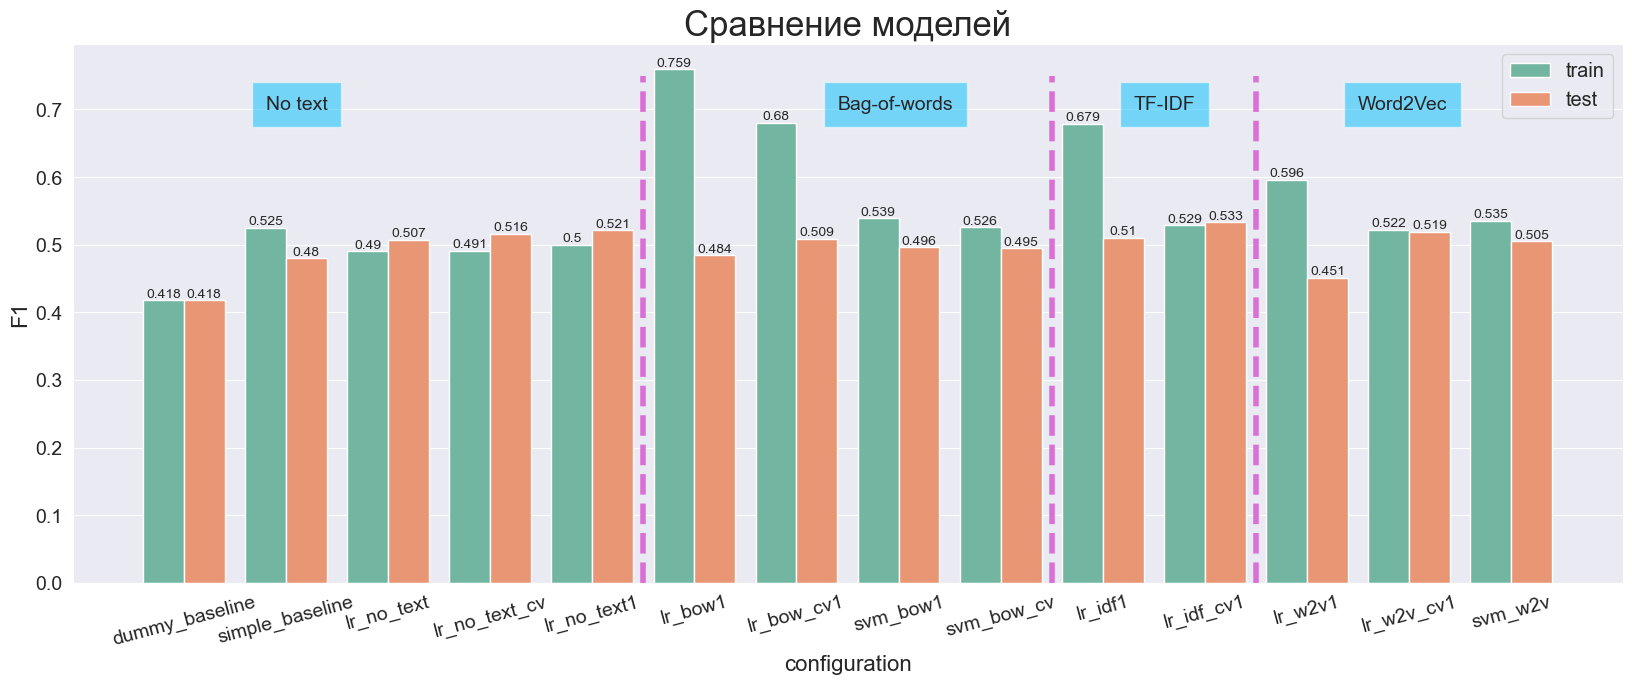

In [113]:
plt.figure(figsize=(20, 7))
b = sns.barplot(data=compare_df.reset_index(level=['configuration', 'set']),
                x='configuration', y='f1', hue='set', palette = 'Set2')
plt.vlines(x=[4.5, 8.5, 10.5], ymin=[0, 0, 0], ymax=[0.75, 0.75, 0.75],
           color='orchid', ls='--', lw=4)
b.axes.set_title("Сравнение моделей", fontsize=25)
b.set_xlabel("configuration", fontsize=16)
b.set_ylabel("F1", fontsize=16)
b.tick_params(labelsize=14)
plt.xticks(rotation=15)
b.bar_label(b.containers[0])
b.bar_label(b.containers[1])
b.text(0.8, 0.7, 'No text', fontsize=14,
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(6.4, 0.7, 'Bag-of-words', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(9.3, 0.7, 'TF-IDF', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(11.5, 0.7, 'Word2Vec', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
plt.legend(fontsize='x-large', title_fontsize='40')
plt.show()

In [138]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
compare_df.drop(('no_text', 'lr_no_text'), axis=0, inplace=True)
compare_df.drop(('no_text', 'lr_no_text_cv'), axis=0, inplace=True)
compare_df.drop(('bow', 'lr_bow1'), axis=0, inplace=True)
compare_df.drop(('bow', 'lr_bow_cv1'), axis=0, inplace=True)
compare_df.drop(('idf', 'lr_idf1'), axis=0, inplace=True)
compare_df.drop(('w2v', 'lr_w2v1'), axis=0, inplace=True)
compare_df.drop(('w2v', 'lr_w2v_cv1'), axis=0, inplace=True)

In [198]:
# compare_df.reset_index(level=['configuration', 'set'])[compare_df.reset_index(level=['configuration', 'set']).set=='test'].sort_values(by='f1')

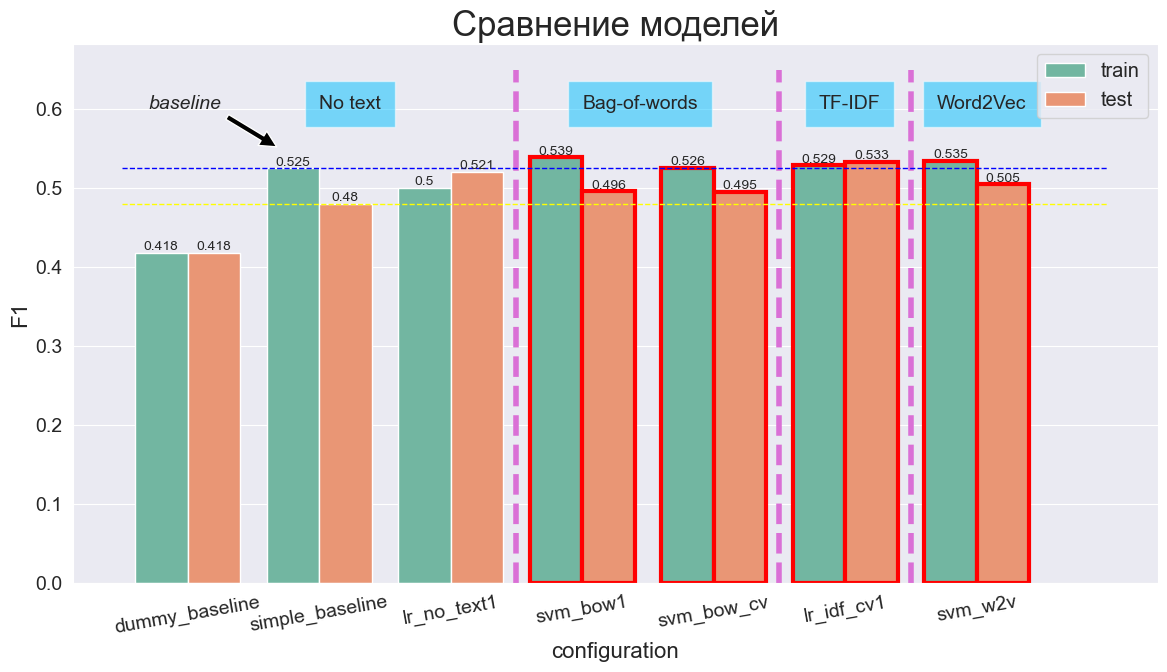

In [142]:
plt.figure(figsize=(14, 7))
b = sns.barplot(data=compare_df.reset_index(level=['configuration', 'set']),
                x='configuration', y='f1', hue='set', palette='Set2')
plt.vlines(x=[2.5, 4.5, 5.5], ymin=[0, 0, 0], ymax=[0.65, 0.65, 0.65],
           color='orchid', ls='--', lw=4)
plt.hlines(y=[0.525, 0.48], xmin=-0.5, xmax=7,
           colors=['blue', 'yellow'], ls='--', lw=1)
b.axes.set_title("Сравнение моделей", fontsize=25)
b.set_xlabel("configuration", fontsize=16)
b.set_ylabel("F1", fontsize=16)
b.tick_params(labelsize=14)
b.bar_label(b.containers[0])
b.bar_label(b.containers[1])
b.text(1, 0.6, 'No text', fontsize=14,
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(3, 0.6, 'Bag-of-words', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(4.8, 0.6, 'TF-IDF', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(5.7, 0.6, 'Word2Vec', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.annotate('baseline', xy=(0.7, 0.55), xytext=(-0.3, 0.6), style='italic',
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
for i in [3, 4, 5, 6]:
    b.patches[i].set(edgecolor='red', linewidth=3)
for i in [10, 11, 12, 13]:
    b.patches[i].set(edgecolor='red', linewidth=3)
plt.xticks(rotation=10)
plt.legend(fontsize='x-large', title_fontsize='40')
plt.show()